In [1]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

df = get_data_index("r1") # all RAM subjects
exp = 'FR1' # 'FR1' 'catFR1'

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/timeseries.py:526: FutureWarning: xarray subclass TimeSeriesX should explicitly define __slots__
  class TimeSeriesX(TimeSeries):


In [2]:
# 575 FR sessions. first 18 of don't load so skip those 
exp_df = df[df.experiment==exp]
if exp == 'FR1':
    exp_df = exp_df[
                    ((df.subject!='R1015J') | (df.session!=0)) & 
                    ((df.subject!='R1063C') | (df.session!=1)) & 
                    ((df.subject!='R1093J') | (~df.session.isin([1,2]))) &
                    ((df.subject!='R1100D') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1120E') | (df.session!=0)) &
                    ((df.subject!='R1122E') | (df.session!=2)) &
                    ((df.subject!='R1154D') | (df.session!=0)) &
                    ((df.subject!='R1186P') | (df.session!=0)) &
                    ((df.subject!='R1201P') | (~df.session.isin([0,1]))) &
                    ((df.subject!='R1216E') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1277J') | (df.session!=0)) &
                    ((df.subject!='R1413D') | (df.session!=0)) & 
                    ((df.subject!='R1123C') | (df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
                    ((df.subject!='R1151E') | (~df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
                    ((df.subject!='R1275D') | (df.session!=3))  # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
    #                 (df.subject!='R1065J') # sub with 9000 trials
                   ] 
if exp == 'catFR1': 
    exp_df = exp_df[
                    ((df.subject!='R1044J') | (df.session!=0)) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1491T') | (~df.session.isin([1,3,5]))) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1486J') | (~df.session.isin([0,1,2,3]))) & # repeated data...will be removed at some point... @@
                    ((df.subject!='R1235E') | (df.session!=0)) & # split EEG filenames error...documented on Asana
                    ((df.subject!='R1310J') | (df.session!=1)) & # session 1 is just a repeat of session 0
                    ((df.subject!='R1239E') | (df.session!=0)) # some correlated noise (can see in catFR1 problem sessions ppt)
    ]
exp_df.shape
# exp_df = exp_df[257:] # for catFR1 this is R1385E-onwwards
# exp_df = exp_df[472:] # for FR1 this is R1385E-onwwards
# exp_df[404:413]
exp_df

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(554, 17)

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
0,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,0,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
1,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,1,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
9,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,0,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
10,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,1,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
17,NaN,protocols/r1/subjects/R1003P/experiments/FR1/s...,protocols/r1/subjects/R1003P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1003P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1003P/localizations/0/m...,NaN,0,R1003P,R1003P,1.0,protocols/r1/subjects/R1003P/experiments/FR1/s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2149,NaN,protocols/r1/subjects/R1462M/experiments/FR1/s...,protocols/r1/subjects/R1462M/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1462M/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1462M/localizations/0/m...,NaN,0,R1462M,R1462M,3.4,protocols/r1/subjects/R1462M/experiments/FR1/s...
2151,NaN,protocols/r1/subjects/R1463E/experiments/FR1/s...,protocols/r1/subjects/R1463E/localizations/1/m...,FR1,build,1,protocols/r1/subjects/R1463E/experiments/FR1/s...,1,NaN,0,protocols/r1/subjects/R1463E/localizations/1/m...,NaN,0,R1463E,R1463E_1,3.4,protocols/r1/subjects/R1463E/experiments/FR1/s...
2152,NaN,protocols/r1/subjects/R1463E/experiments/FR1/s...,protocols/r1/subjects/R1463E/localizations/1/m...,FR1,build,1,protocols/r1/subjects/R1463E/experiments/FR1/s...,1,NaN,1,protocols/r1/subjects/R1463E/localizations/1/m...,NaN,1,R1463E,R1463E_1,3.4,protocols/r1/subjects/R1463E/experiments/FR1/s...
2166,NaN,protocols/r1/subjects/R1466J/experiments/FR1/s...,protocols/r1/subjects/R1466J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1466J/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1466J/localizations/0/m...,NaN,0,R1466J,R1466J,3.4,protocols/r1/subjects/R1466J/experiments/FR1/s...


In [ ]:
## Now to load data from cluster, have to go through and append across sessions

### params that clusterRun used (note that exp is defined in first cell so can get exp_df above)
selected_period = 'surrounding_recall' # surrounding_recall # whole_retrieval # encoding 
region_name = 'HPC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC # PHC 
remove_soz_ictal = False
recall_type_switch = 3 # for the og 2000 IRI

# Instead of loading by recall_type now...just load across this range of IRI values I use to label the folders:
IRI_values_ran = np.arange(800,5000,100) #[1000,1250,1500,1750,2000,2250,2500]
###

# get strings for path name for save and loading cluster data
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period)

# Makes most sense to take half the subjects 
if exp == 'FR1':
    np.random.seed(44462) # seed 44462 gives 25,845 of 60,417 recall trials (42.8%). Or 57/167 (34.1% of subs)
    from SWRmodule import total_sub_names_FR1 # all the unique sub names for FR1 task in df
    total_sub_names = copy(total_sub_names_FR1)
    proportion_subs = 0.5 # it's really 0.5 of initial pre-localization.pairs subs. So comes out to numbers above. And what we want to match for catFR1
elif exp == 'catFR1':
    np.random.seed(44455) # seed 44455 gives 20,393 of 50,053 recall trials (40.7%). Or 47/136 (34.6% of subs)
    from SWRmodule import total_sub_names_catFR1 # all the unique sub names for FR1 task in df
    total_sub_names = copy(total_sub_names_catFR1)
    proportion_subs = 0.35 # 0.5
random_half_sub_names = np.random.permutation(np.unique(total_sub_names))[:int(np.floor(len(np.unique(total_sub_names))*proportion_subs))]
random_half_sub_names[:10] # just to see them
random_half_sub_names[-10:]
half_sub_idxs = np.array(findAinB(random_half_sub_names,exp_df.subject))
half_df = exp_df.iloc[half_sub_idxs]


tvalue_save = []
stderr_save = []
pvalue_save = []
total_trials_save = []

for IRI in IRI_values_ran:  
    
    ripple_array = []; 
    trial_nums = []; encoded_word_key_array = []; serialpos_array = []
    HPC_names = []; sub_sess_names = []
    region_electrode_ct = []; sub_names = []
    trial_by_trial_correlation = []; elec_ripple_rate_array = []
    elec_by_elec_correlation = []; fr_array = []

    ordinal_position_array = []; electrode_labels = []
    channel_coords = []

    for row in half_df.itertuples(): #sub_df.itertuples():  #half_df.itertuples(): ### DON'T CHANGE THIS TO EXP
        try:
            sub = row.subject; session = row.session; exp = row.experiment
            
            recall_selection_name = 'SOLONOCOMPOUND'+str(IRI)
            path_name = '/scratch/john/SWR_scratch/'+recall_selection_name
            fn = os.path.join(path_name,
                'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+'_'+soz_label+'.p')                
                
            with open(fn,'rb') as f:
                dat = pickle.load(f)

    #             # load this first since it was last thing added, so old files won't keep going past this
    #             if selected_period == 'surrounding_recall':
    #                 if dat['ripple_array'].shape[0] != len(dat['ordinal_position_array']):
    #                     print(sub+str(session))
    #                 ordinal_position_array.extend(dat['ordinal_position_array'])

                ripple_array = superVstack(ripple_array,dat['ripple_array']) 
                region_electrode_ct.append(dat['region_electrode_ct'])
                encoded_word_key_array.extend(dat['encoded_word_key_array'])
                HPC_names.extend(dat['HPC_names'])
                sub_sess_names.extend(dat['sub_sess_names'])
                sub_names.extend(dat['sub_names'])
                trial_nums = np.append(trial_nums,dat['trial_nums'])
                trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
                elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
                elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
                #,'total_recalls':total_recalls, 'kept_recalls':kept_recalls}, f)
                if selected_period == 'whole_retrieval':
                    if np.shape(dat['fr_array'])[0]!=np.shape(dat['ripple_array'])[0]:
                        print(sub+str(session))
                    fr_array = superVstack(fr_array,dat['fr_array'])
                if selected_period == 'encoding':
                    serialpos_array.extend(dat['serialpos_array'])
                electrode_labels.extend(dat['electrode_labels'])
                channel_coords.extend(dat['channel_coords'])
                
                
        except Exception as e:
            LogDFExceptionLine(row, e, 'ClusterLoadSWR_log.txt')
            
    print('**Done loading '+str(IRI)+' ms**')
    
    ### data loaded for this IRI. Now get the z-score for our key test ###

    select_subfield = False   # note: if you already ran this once, have to load again from data
                              # also this is only for HPC. So set to FALSE for ENT and PHC

    # select for subfield if HPC
    if select_subfield == True:
        location_selected = 'dg' #['dg','ca1'] #'dg' # 'ca3' # 'dg' 'ca1' # sub 
            # left # right # left hippocampus # right hippocampus # hippocampus
            # to see number of each: sum(np.array([names.find('sub') for names in HPC_names])>=0)
    else:
        location_selected = ''
    desired_sample_rate = 500.
    sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
    sr_factor = 1000/desired_sample_rate

    start_array,end_array = getStartEndArrays(ripple_array) # get start array

    subject_name_array,session_name_array,electrode_array,channel_coords_array = getSubSessPredictors(sub_names,sub_sess_names,
                                                                                trial_nums,electrode_labels,channel_coords)

    selected_recalls = np.ones(len(start_array),dtype=bool)

    # get locations if selected

    if select_subfield == True:
        # create the full vector of location name predictors
        location_names = []
        for s in range(len(HPC_names)):
            new_trials = int(trial_nums[s])
            location_names.extend(np.tile(HPC_names[s],new_trials))  

        # now can get mask of trials in this location

        #first, if there are two locations to combine, sort that out (DG and CA1 in particular)
        location_mask = np.zeros(len(location_names))
        for s in range(len(location_names)):
            if type(location_selected)==list:
                if location_names[s].find(location_selected[0])>=0 or location_names[s].find(location_selected[1])>=0:
                    location_mask[s] = True
            elif type(location_selected)==str:
                if location_names[s].find(location_selected)>=0:
                    location_mask[s] = True
    else:
        location_mask = np.ones(len(start_array))

    # combine location and sorted recalls to get new ripple array:
    updated_recalls = (location_mask+selected_recalls)==2

    # translate these predictors to vector and select recalls
    start_array = start_array[updated_recalls]
    subject_name_array = np.array(subject_name_array)[updated_recalls]
    session_name_array = np.array(session_name_array)[updated_recalls]
    electrode_array = np.array(electrode_array)[updated_recalls]
    channel_coords_array = np.array(channel_coords_array)[updated_recalls]


    print('Got start_array with '+str(start_array.shape[0])+' trials!')


    # make a PSTH based on start times of SWRs
    bin_size = 100 # in ms
    smoothing_triangle = 5 # triangular smoothing window width
    samples = 100
    pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?
    psth_start = -2000
    psth_end = 2000

    PSTH,bin_centers = fullPSTH(start_array,bin_size,smoothing_triangle,sr,psth_start)
    # bootstraps error bars by sampling from trials in raster with replacement samples number of
    # times and then taking the standard deviation across those samples
    # boot_samples = bootstrap(start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
    #                bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,psth_start))
    # boot_SD = np.std(boot_samples,0)

    # get binned start array (trials X bins)
    binned_start_array = binBinaryArray(start_array,bin_size,sr_factor)
    if pad > 0:
        binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
    print('done making binned start_array with shape:')
    binned_start_array.shape

    # # get trial X 1 categorical names for subjects and sessions # do this in start_array cell now
    # if select_ordinal_position == 0: # if 0 already did this in last cell
    #     subject_name_array,session_name_array = getSubSessPredictors(sub_names,sub_sess_names,trial_nums)

    # let's measure significance at two key 500 ms bins (and compare to similar bin 500 ms earlier/later)
    stats_bin = 500 # time bin width in ms to test stats on

    first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
    first_end = -100
    second_start = 200 # same idea
    second_end = 1700

    start_array.shape
    binned_first_stats_array = start_array[:,int((first_start-psth_start)/sr_factor):int((first_end-psth_start)/sr_factor)]
    binned_second_stats_array = start_array[:,int((second_start-psth_start)/sr_factor):int((second_end-psth_start)/sr_factor)]
    binned_first_stats_array = binBinaryArray(binned_first_stats_array,stats_bin,sr_factor)
    binned_second_stats_array = binBinaryArray(binned_second_stats_array,stats_bin,sr_factor)
    print('done binning start_arrays'); binned_start_array.shape

    bin_model1 = MEstatsAcrossBins(binned_first_stats_array[:,[0,2]],subject_name_array,session_name_array)
#                 bin_model2 = MEstatsAcrossBins(binned_second_stats_array[:,[0,2]],subject_name_array,session_name_array)
    tvalue_save.append(bin_model1.params[1])
    stderr_save.append(bin_model1.bse[1])
    pvalue_save.append(bin_model1.pvalues[1])
    total_trials_save.append(len(binned_start_array))

save_IRI_data = 1

if save_IRI_data == 1:
    path_name = '/home1/john/SWR/figures/parametric_IRI'
    fn = os.path.join(path_name,
        'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+'.p')            
    with open(fn,'wb') as f:
        pickle.dump({'tvalue_save':tvalue_save,'stderr_save':stderr_save,
                     'pvalue_save':pvalue_save,'total_trials_save':total_trials_save}, f)
    

array(['R1325C', 'R1310J', 'R1077T', 'R1288P', 'R1044J', 'R1108J',
       'R1002P', 'R1131M', 'R1316T', 'R1215M'], dtype='<U6')

array(['R1306E', 'R1137E', 'R1105E', 'R1048E', 'R1138T', 'R1122E',
       'R1094T', 'R1236J', 'R1120E', 'R1338T'], dtype='<U6')

2020-10-15_16-21-43: DF Exception: Sub: R1147P, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/SOLONOCOMPOUND800/SWR_FR1_R1147P_0_HPC_surrounding_recallSOLONOCOMPOUND800_soz_in.p', file: <ipython-input-60-efec5d6dbb93>, line no: 60
2020-10-15_16-21-48: DF Exception: Sub: R1243T, Sess: 3, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/SOLONOCOMPOUND800/SWR_FR1_R1243T_3_HPC_surrounding_recallSOLONOCOMPOUND800_soz_in.p', file: <ipython-input-60-efec5d6dbb93>, line no: 60
2020-10-15_16-21-53: DF Exception: Sub: R1342M, Sess: 1, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/SOLONOCOMPOUND800/SWR_FR1_R1342M_1_HPC_surrounding_recallSOLONOCOMPOUND800_soz_in.p', file: <ipython-input-60-efec5d6dbb93>, line no: 60
**Done loading 800 ms**


In [61]:
tvalue_save
stderr_save

[0.0659687133675573,
 0.06706081779468312,
 0.06767519278580755,
 0.06672989050780236,
 0.07000439174352224,
 0.07162410806444372,
 0.07466301119488232,
 0.07490322279744416,
 0.07935595169637724,
 0.08128405242232364,
 0.08408836404357123,
 0.08726094680739889,
 0.08752096067506909,
 0.08934177912420811,
 0.09142212189616244,
 0.09165075507724345,
 0.09163939303778651,
 0.08957055214723923,
 0.09037055709604243,
 0.08928686465245123,
 0.09123036649214655,
 0.09373549883990716,
 0.09437264404954218,
 0.09293040545191697,
 0.0923098278734036,
 0.09614159292035397,
 0.09692960379664908,
 0.09573770491803268,
 0.09362079149438844,
 0.09367996414164038,
 0.09156844968268374,
 0.08901486134518162,
 0.0939025335089486,
 0.09292486092611467,
 0.09103863204559853,
 0.08871160749900275,
 0.08940344106769571,
 0.09045879009338202,
 0.09038162948435073,
 0.0897288414133113,
 0.08809622563251755,
 0.08597697341174512]

[0.008392962265603304,
 0.00850697092303083,
 0.008610601008754954,
 0.008718359734613539,
 0.008745892796166499,
 0.008849162052150885,
 0.008915197939885553,
 0.00900618864450538,
 0.009134122500838102,
 0.009250829038329139,
 0.009399800996388095,
 0.009548433305655316,
 0.00970518243778653,
 0.009768082855823063,
 0.009903164496342341,
 0.010009745378299378,
 0.010186849049486215,
 0.01032457434299698,
 0.010470594995218886,
 0.01056975007166834,
 0.010660660120660989,
 0.01073015944262625,
 0.010794619262986953,
 0.010912101860666185,
 0.010966025548269562,
 0.011086633649620505,
 0.011171621909850047,
 0.011243416924769826,
 0.011327998588076737,
 0.011395998563999062,
 0.011424571325386362,
 0.01151065466430953,
 0.011565001480111388,
 0.011623421909970847,
 0.011681012056237436,
 0.011724755631364592,
 0.011778469908558119,
 0.011843284191336283,
 0.011871081024999269,
 0.011890357762958948,
 0.011974481205847235,
 0.011952704837543586]

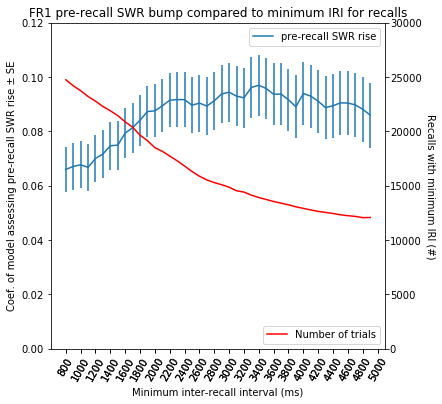

In [115]:
# and the first axes using subplot populated with data 
fig1 = figure(figsize=(6,6))

ax = ax1 = fig1.add_subplot(111)

xr=np.arange(1,len(tvalue_save)+1)
line1 = errorbar(xr,tvalue_save,stderr_save)

xr_ticks = np.arange(1,len(tvalue_save)+2,2)
xr_tick_values = np.arange(min(IRI_values_ran),max(IRI_values_ran)+200,200)

xticks(xr_ticks,xr_tick_values,rotation=60)
ax.set_ylim(0,0.12)
xlabel('Minimum inter-recall interval (ms)')
ylabel('Coef. of model assessing pre-recall SWR rise ± SE')
title(exp+' pre-recall SWR bump compared to minimum IRI for recalls')

ax2 = fig1.add_subplot(111, sharex=ax, frameon=False)
line2 = ax2.plot(xr,total_trials_save, 'r-')
ax2.set_ylim(0,30000)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
xticks(xr_ticks,xr_tick_values,rotation=60)
ax2.set_ylabel('Recalls with minimum IRI (#)',rotation=270,verticalalignment='bottom')
ax1.legend(line1,{"pre-recall SWR rise"})
ax2.legend(line2,{"Number of trials"},loc='lower right')
ax2.tick_params(axis='y', which='major', pad=1);

In [12]:
len(tvalue_save)

7